In [13]:
import sys
import os

project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.append(project_root)
 
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [14]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd

COLOR_PALETTE = [
    "#05a298",
    "#0070bc",
    "#d06b6d",
    "#a8e667",
    "#57832e",
    "#56ebd3",
    "#0a4f4e",
    "#9ecbf4",
]

sns.set_theme(style="white")
plt.rcParams["figure.figsize"] = (12, 6)
# sns.set_palette(COLOR_PALETTE)
pd.set_option("display.max_columns", None)


CAMBIOS_GLOSAS = {
    "Región Del Bíobío": "Región del Bío-Bío",
    "Región Metropolitana de Santiago": "Región Metropolitana de Santiago",
    "Región del Libertador General Bernardo O'Higgins": "Región del Libertador Bernardo O'Higgins",
    "Región De Antofagasta": "Región de Antofagasta",
    "Región De Los Lagos": "Región de Los Lagos",
    "Región Del Maule": "Región del Maule",
    "Región De Valparaíso": "Región de Valparaíso",
    "Región De Arica y Parinacota": "Región de Arica y Parinacota",
    "Región De Tarapacá": "Región de Tarapacá",
    "Región Aysén del General Carlos Ibáñez del Campo": "Región de Aysén del Gral.Ibañez del Campo",
    "Región De Coquimbo": "Región de Coquimbo",
    "Región De Magallanes y de La Antártica Chilena": "Región de Magallanes y Antártica Chilena",
    "Región De La Araucanía": "Región de La Araucanía",
    "Región De Atacama": "Región de Atacama",
    "Región De Ñuble": "Región de Ñuble",
    "Región De Los Ríos": "Región de Los Ríos",
}

In [15]:
df = pd.read_csv("../data/processed/df_procesada.csv")

In [16]:
# Eliminamos las filas que no tienen fecha de evaluación
df_limpia = df.dropna(subset="fecha_1_evaluacion").copy()
df_limpia = df_limpia.query("anio_1_evaluacion >= 2000 and anio_1_evaluacion <= 2022")

df_limpia["region"] = df_limpia["region"].str.replace(", Chile", "")
df_limpia["region"] = df_limpia["region"].replace(CAMBIOS_GLOSAS)

df_limpia["fecha_1_evaluacion"] = pd.to_datetime(df_limpia["fecha_1_evaluacion"])
df_limpia["f_nac"] = pd.to_datetime(df_limpia["f_nac"])
df_limpia["edad_1_evaluacion_calc"] = (
    df_limpia["fecha_1_evaluacion"] - df_limpia["f_nac"]
).dt.days / 365

In [17]:
df_limpia["prevision"] = df_limpia["prevision"].str.upper()

In [18]:
# Obtiene la cantidad de pacientes anuales
cantidad_de_pacientes = df_limpia.groupby("anio_1_evaluacion")["rut"].nunique()

# Obtiene la distribucion de la prevision a lo largo de los anios
prevision = df_limpia.groupby(["prevision"])["rut"].nunique()
# prevision.loc["Total", :] =  prevision.sum()

# Obtiene la distribucion de la 1era edad de consulta
edad_primera_consulta = df_limpia.groupby("anio_1_evaluacion")["edad_1_evaluacion_calc"].describe()

# Obtiene el desglose por region
desglose_por_region = df_limpia.groupby("region")["rut"].nunique()

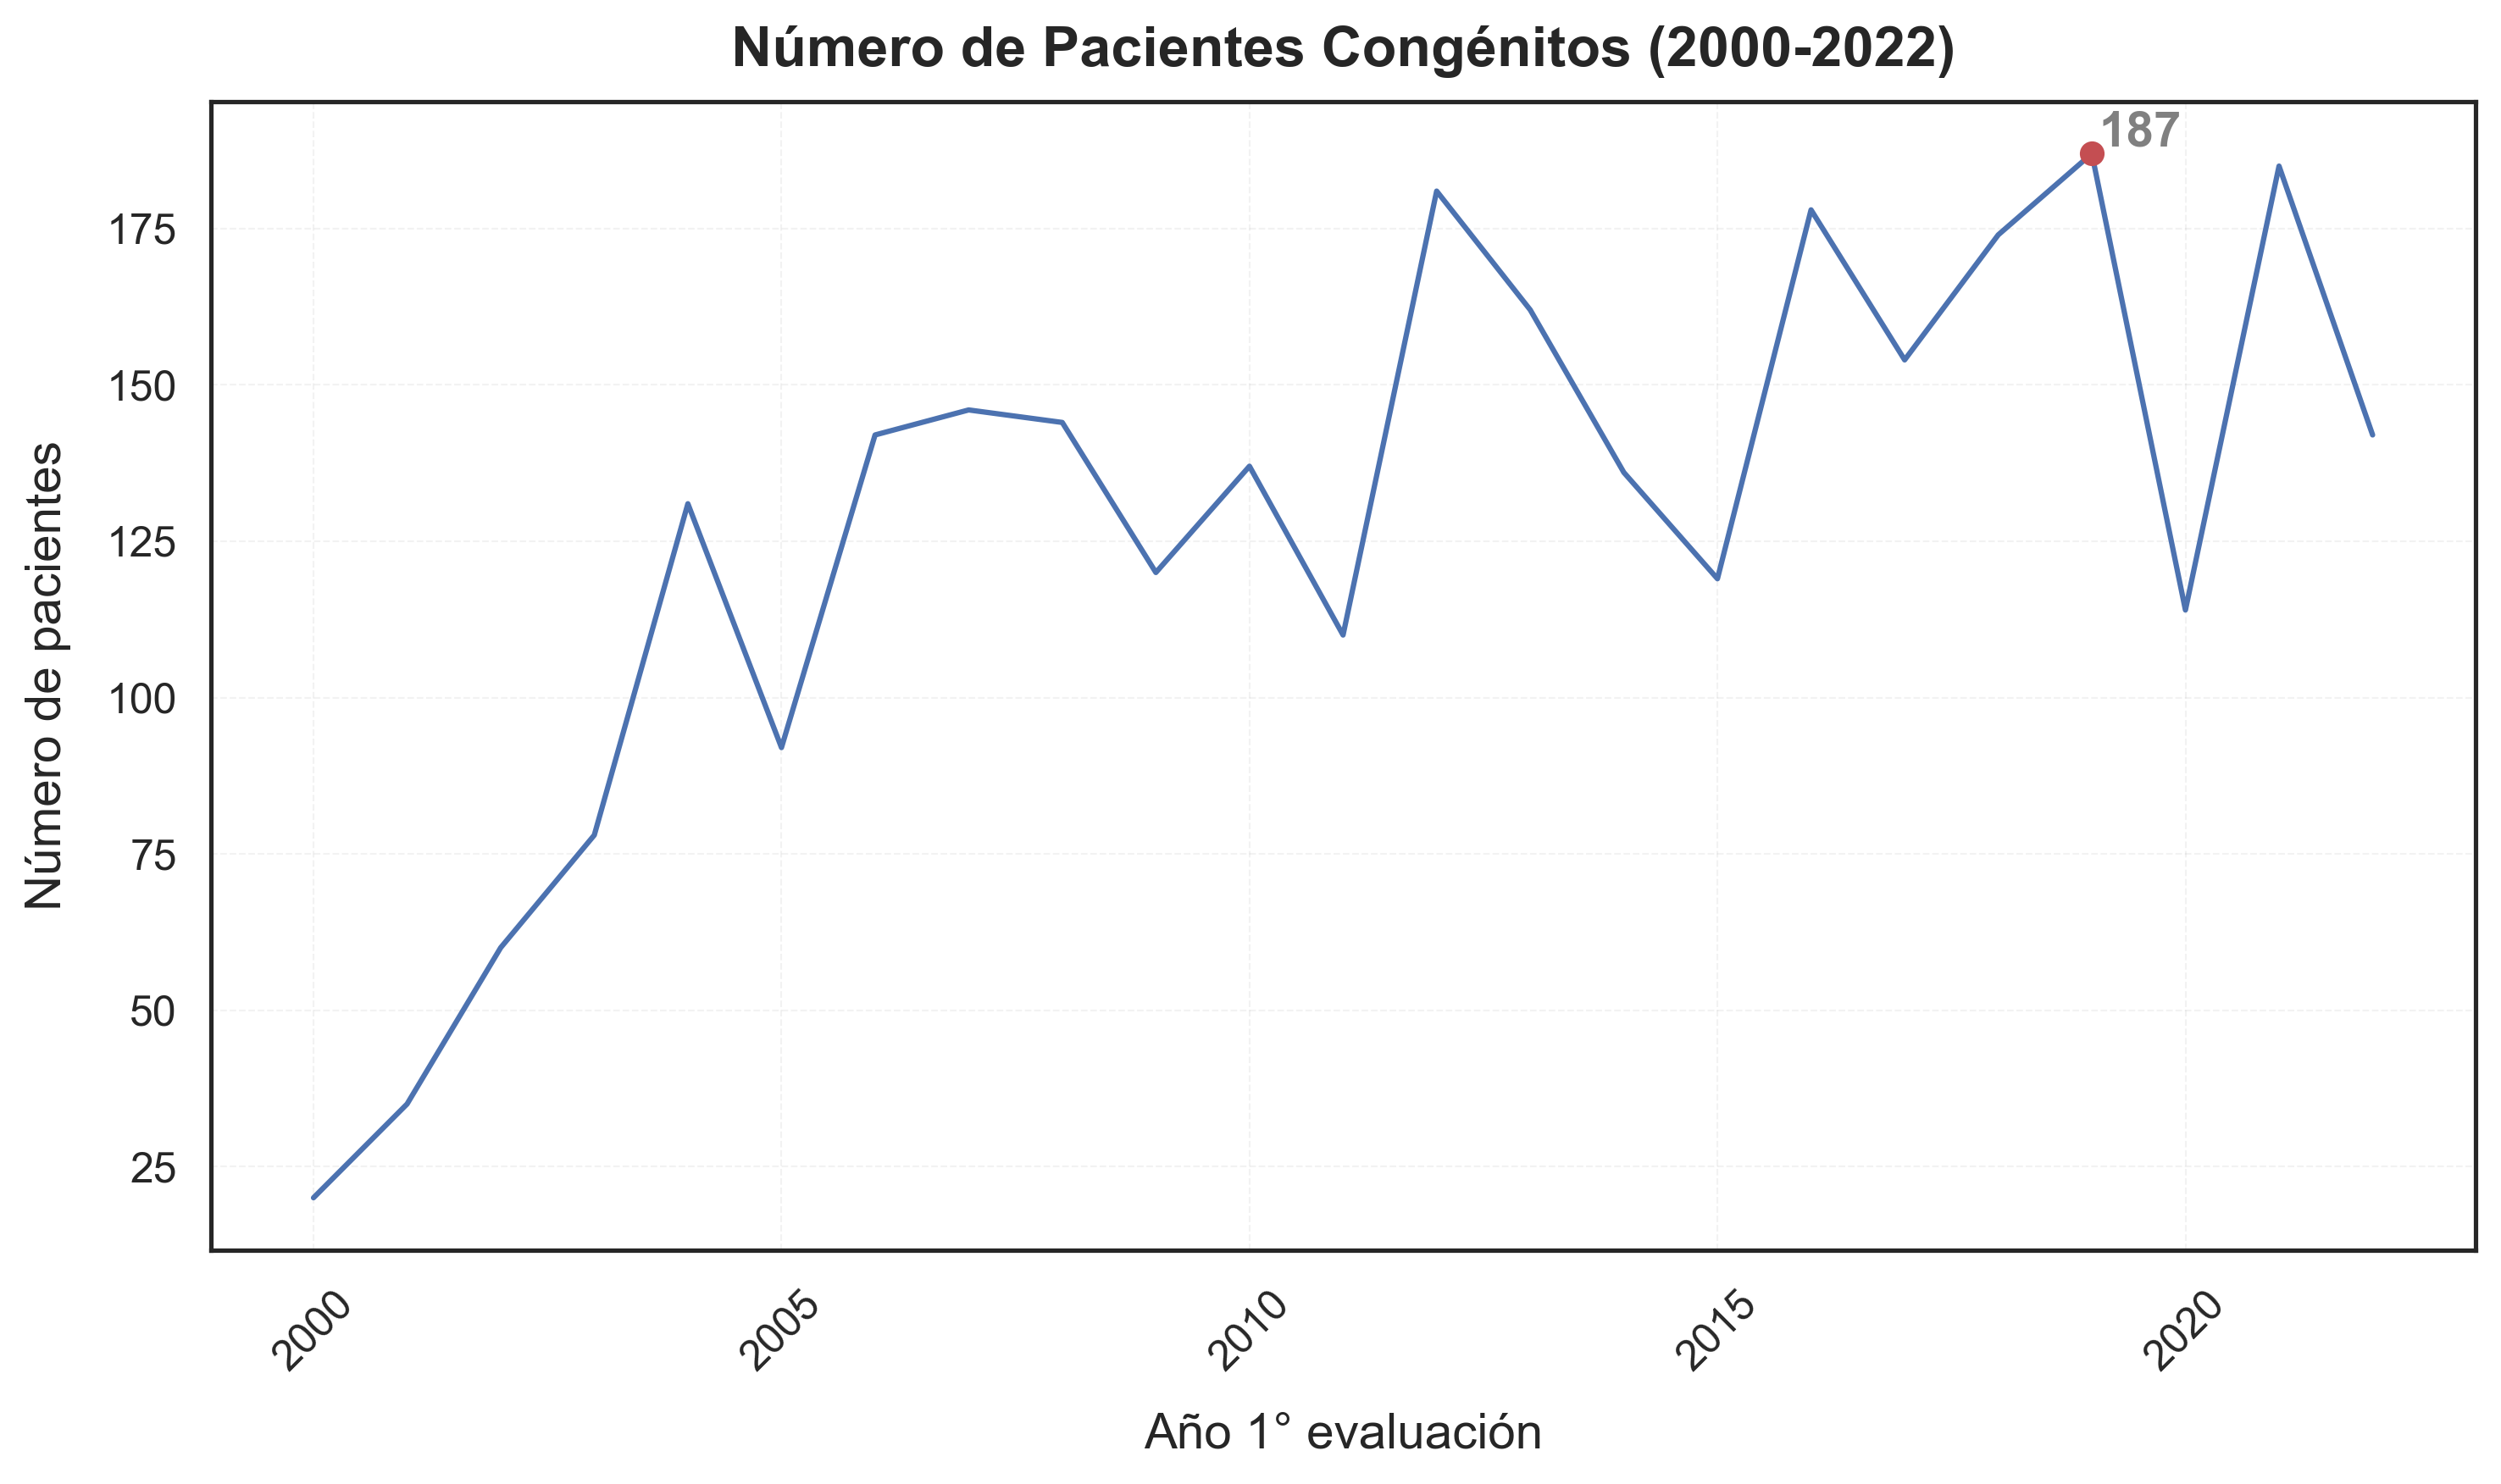

In [19]:
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
cantidad_de_pacientes.plot(ax=ax)

ax.set_title(
    "Número de Pacientes Congénitos (2000-2022)", fontsize=16, weight="bold", pad=10
)
ax.set_xlabel("Año 1° evaluación", fontsize=14, labelpad=10)
ax.set_ylabel("Número de pacientes", fontsize=14, labelpad=10)

# Rotate x-axis labels for clarity
plt.xticks(fontsize=12, rotation=45)
plt.yticks(fontsize=12)

# Obtiene el punto en el 2019 (mayor cantidad de pacientes)
ANIO_MAXIMO = cantidad_de_pacientes.idxmax()
anio_ANIO_MAXIMO = cantidad_de_pacientes.loc[ANIO_MAXIMO]
ax.plot(ANIO_MAXIMO, anio_ANIO_MAXIMO, "ro")
# Annotate the point with its value
ax.annotate(
    f"{anio_ANIO_MAXIMO}",
    xy=(ANIO_MAXIMO, anio_ANIO_MAXIMO),
    xytext=(2, 2),
    textcoords="offset points",
    fontsize=14,
    color="grey",
    weight="bold"
)

# Add a grid for better readability
ax.grid(visible=True, which="major", linestyle="--", linewidth=0.5, color="gray", alpha=0.1)

fig.tight_layout()

plt.savefig("../reports/figures/numero_de_pacientes.png", dpi=300, bbox_inches="tight")

plt.show()

<Axes: ylabel='rut'>

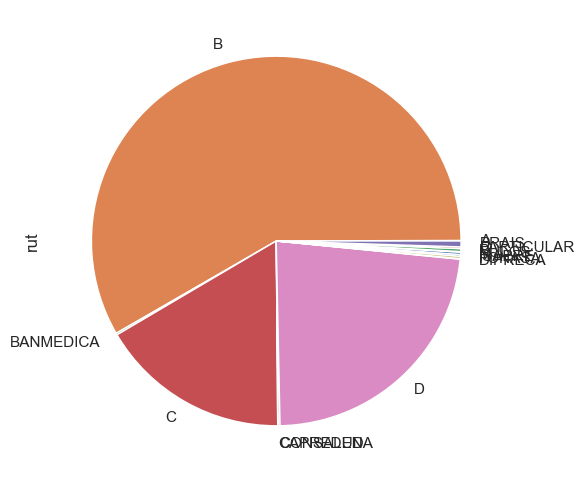

In [20]:
prevision.plot(kind="pie")

In [21]:
map_df = gpd.read_file("../data/raw/mapas/Regional.shp")

In [22]:
# Join the data
resumen_regiones = map_df.set_index("Region").join(desglose_por_region)

# Filter the GeoDataFrame to include only the polygons within the bounding box
resumen_regiones_filtrado = resumen_regiones.cx[:, :]

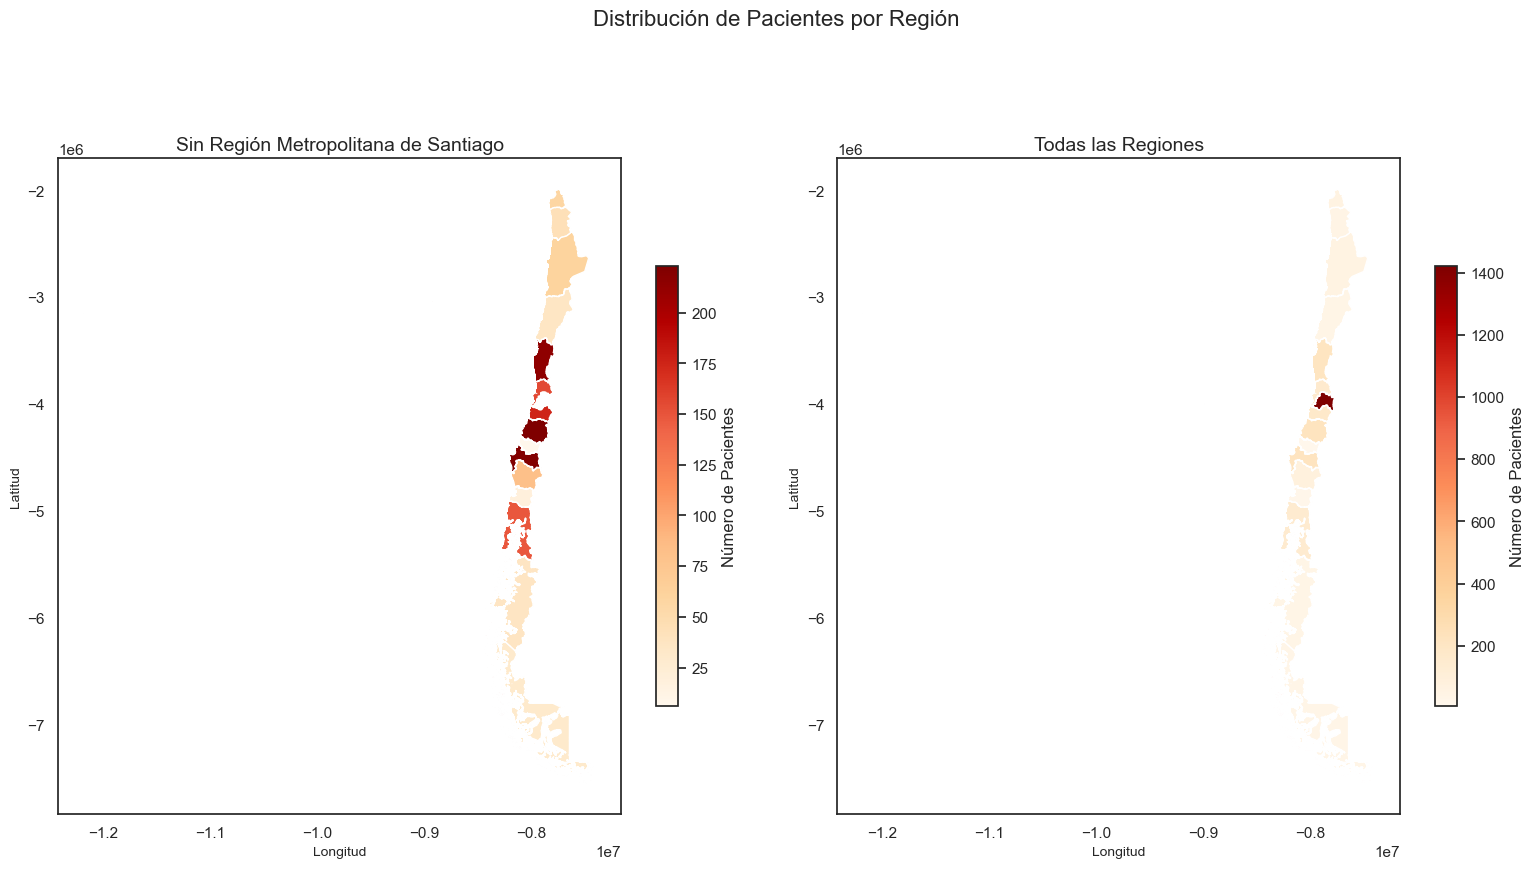

In [24]:
# Set the figure size and aspect ratio
fig, ax = plt.subplots(1, 2, figsize=(16, 10))  # Wider layout for better separation of subplots

# Plot the filtered GeoDataFrame without the specified region on the first subplot
resumen_regiones_filtrado.query("Region != 'Región Metropolitana de Santiago'").plot(
    column="rut",
    cmap="OrRd",
    ax=ax[0],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Shrink the colorbar to 50% of its original size
        "label": "Número de Pacientes",  # Add a label to the colorbar
        "orientation": "vertical"  # Keep the legend vertical
    }
)

# Plot the filtered entire GeoDataFrame on the second subplot
resumen_regiones_filtrado.plot(
    column="rut",
    cmap="OrRd",
    ax=ax[1],
    legend=True,
    legend_kwds={
        "shrink": 0.5,  # Match the size of the colorbar with the first subplot
        "label": "Número de Pacientes",
        "orientation": "vertical"
    }
)

# Set titles for each subplot
ax[0].set_title("Sin Región Metropolitana de Santiago", fontsize=14)
ax[1].set_title("Todas las Regiones", fontsize=14)

# Add axis labels for clarity
for axis in ax:
    axis.set_xlabel("Longitud", fontsize=10)
    axis.set_ylabel("Latitud", fontsize=10)

# Overall plot title
fig.suptitle("Distribución de Pacientes por Región", fontsize=16, y=0.95)

# Adjust spacing between plots and tighten layout
plt.tight_layout(pad=2)

# Show the plot
plt.show()